In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import time
from datetime import datetime
import networkx as nx
import torch
import torch.optim as optim
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import copy
import glob
import shutil
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import torch
from torch_scatter import scatter_add
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip

In [231]:
class MCDataset(InMemoryDataset):
    def __init__(self, root,  transform=None, pre_transform=None):
        #self.name = name
        super(MCDataset, self).__init__(root, transform, pre_transform)

        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def num_relations(self):
        return self.data.edge_type.max().item() + 1

    @property
    def num_nodes(self):
        return self.data.x.shape[0]

    @property
    def raw_file_names(self):
        return ['onewaydata.csv','labelen.csv']

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        
        pass

    def process(self):

        train_csv = self.raw_paths
        train_df, train_nums, lab = self.create_df(train_csv)
        train_df['item_id'] = train_df['item_id'] + train_nums['user']

        x = torch.eye(train_nums['node'], dtype=torch.long)
        
        # Prepare edges
        edge_user = torch.tensor(train_df['user_id'].values)
        edge_item = torch.tensor(train_df['item_id'].values)

        edge_index = torch.stack((torch.cat((edge_user, edge_item), 0),
                                  torch.cat((edge_item, edge_user), 0)), 0)
        edge_index = edge_index.to(torch.long)

        # Prepare data
        data = Data(x=x, edge_index=edge_index)

        data.num_users = torch.tensor(train_nums['user'])
        data.num_items = torch.tensor(train_nums['item'])       
        
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

    def create_df(self, csv_path):
        df = pd.read_csv(csv_path[0])
        df = df.drop('Unnamed: 0', axis=1)

        nums = {'user': df.max()['user_id'] + 1,
                'item': df.max()['item_id'] + 1,
                'node': df.max()['user_id'] + df.max()['item_id'] + 2,
                'edge': len(df)}
        return df, nums, lab


    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, 'data.pt'))
        return data[0]

    def __repr__(self):
        return '{}{}()'.format(self.name.upper(), self.__class__.__name__)


if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = MCDataset(root='./data/cri_cluster_service')
    data = dataset[0]
    
    data = data.to(device)
data

Data(edge_index=[2, 155066], num_items=1790, num_users=2196, x=[3986, 3986])

In [232]:
class Encoder(torch.nn.Module):
    '''
    Encoder : Graph Conv to get embeddings 
    Decoder : inner product 
    '''
    
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)
        self.dropout=0.5
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    
    loss = model.recon_loss(z, train_pos_edge_index)    # reconstruction loss 
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

    return loss.item()

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

def pred(x,pred_dege_index,sigmoid=False):
    model.eval()
    with torch.no_grad():
        pred_dege_index=pred_dege_index.to(device)
        z = model.encode(x,train_pos_edge_index)
        torch.save(z,'tensor.pt')
        pred = (z[pred_dege_index[0]] * z[pred_dege_index[1]]).sum(dim=1)
        
        return torch.sigmoid(pred) if sigmoid else pred

In [233]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())
# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(len(data.x), channels)).to(dev)
data.test_gt = data.test_idx = data.train_gt = data.train_idx = None

# data = model.split_edges(data) # split_edges unavilable 
data = pyg_utils.train_test_split_edges(data, val_ratio=0.2, test_ratio=0.2)   # construct positive/negative edges (for negative sampling!)

x, train_pos_edge_index = data.x.float().to(dev), data.train_pos_edge_index.to(dev) # float long

optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

CUDA availability: True


In [234]:
# training and validation
Auc = []
for epoch in range(1, 21):
    los = train(epoch)
    loss.append(los)
    auc= test(data.test_pos_edge_index, data.test_neg_edge_index)[0]
    writer.add_scalar("AUC", auc, epoch)
    Auc.append(auc)
    print('Epoch: {:03d}, AUC: {:.4f}'.format(epoch, auc))

Epoch: 001, AUC: 0.8292
Epoch: 002, AUC: 0.8370
Epoch: 003, AUC: 0.8385
Epoch: 004, AUC: 0.8388
Epoch: 005, AUC: 0.8389
Epoch: 006, AUC: 0.8390
Epoch: 007, AUC: 0.8392
Epoch: 008, AUC: 0.8406
Epoch: 009, AUC: 0.8434
Epoch: 010, AUC: 0.8465
Epoch: 011, AUC: 0.8493
Epoch: 012, AUC: 0.8516
Epoch: 013, AUC: 0.8530
Epoch: 014, AUC: 0.8536
Epoch: 015, AUC: 0.8538
Epoch: 016, AUC: 0.8540
Epoch: 017, AUC: 0.8541
Epoch: 018, AUC: 0.8541
Epoch: 019, AUC: 0.8540
Epoch: 020, AUC: 0.8539


In [235]:
# testing
z = model.encode(x, train_pos_edge_index)
test_auc = model.test(z, data.val_pos_edge_index, data.val_neg_edge_index)[0]
test_auc

0.8543507825091576

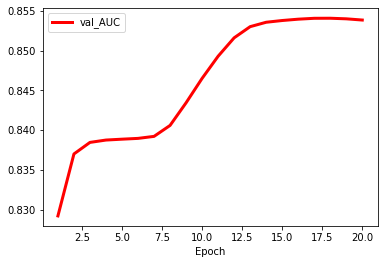

<Figure size 432x288 with 0 Axes>

In [236]:
y1=Auc
x1=range(1,21)
plt.plot(x1,y1,label='val_AUC',linewidth=3,color='r',
markerfacecolor='blue',markersize=12)
plt.xlabel('Epoch')
plt.legend()
plt.show()
#plt.savefig("val_auc.png")

In [253]:
# save z
pred(x=x,pred_dege_index=data.test_neg_edge_index)
pred(x=x,pred_dege_index=data.test_neg_edge_index).mean()

tensor(0.3872, device='cuda:0')

In [254]:
pred(x=x,pred_dege_index=data.test_pos_edge_index).mean()

tensor(0.9340, device='cuda:0')

In [248]:
z = torch.load('tensor.pt')
z

tensor([[-0.0682,  0.3922, -0.2613,  ..., -0.1434,  0.0611,  0.1198],
        [-0.0282,  0.2125, -0.1399,  ..., -0.0726,  0.0261,  0.0592],
        [-0.0312,  0.2248, -0.1487,  ..., -0.0788,  0.0273,  0.0646],
        ...,
        [-0.0326,  0.2281, -0.1507,  ..., -0.0842,  0.0354,  0.0719],
        [-0.0157,  0.1382, -0.0890,  ..., -0.0564,  0.0183,  0.0409],
        [ 0.0299,  0.0348, -0.0215,  ..., -0.0231,  0.0046,  0.0031]],
       device='cuda:0')

In [247]:
model.encode(x, train_pos_edge_index)

tensor([[-0.0682,  0.3922, -0.2613,  ..., -0.1434,  0.0611,  0.1198],
        [-0.0282,  0.2125, -0.1399,  ..., -0.0726,  0.0261,  0.0592],
        [-0.0312,  0.2248, -0.1487,  ..., -0.0788,  0.0273,  0.0646],
        ...,
        [-0.0326,  0.2281, -0.1507,  ..., -0.0842,  0.0354,  0.0719],
        [-0.0157,  0.1382, -0.0890,  ..., -0.0564,  0.0183,  0.0409],
        [ 0.0299,  0.0348, -0.0215,  ..., -0.0231,  0.0046,  0.0031]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [252]:
np.loadtxt('zz_np', dtype=np.float32, delimiter=',')
#np.savetxt("zz_np", z.cpu().numpy(), delimiter=",")

array([[-0.06824425,  0.392174  , -0.26132175, ..., -0.14340872,
         0.06108829,  0.11977644],
       [-0.02824281,  0.21247101, -0.13992754, ..., -0.072564  ,
         0.02610571,  0.05924575],
       [-0.03115176,  0.22480527, -0.14867544, ..., -0.07881824,
         0.02732685,  0.06458895],
       ...,
       [-0.03264828,  0.22813232, -0.15069732, ..., -0.08419894,
         0.03538143,  0.07187975],
       [-0.0157146 ,  0.13817778, -0.0890188 , ..., -0.05636573,
         0.01833604,  0.04087294],
       [ 0.02994923,  0.03484719, -0.02148308, ..., -0.02311425,
         0.00459817,  0.00305431]], dtype=float32)